In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91907\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('data_unique.csv',encoding = 'UTF-8')

In [3]:
df.review = df.review.astype(str)

In [4]:
df.head()

,restaurant,restaurant_type,rating,review
0,Jalsa,Casual Dining,4.0,A beautiful place to dine in The interiors tak...
1,Jalsa,Casual Dining,4.0,I was here for dinner with my family on a week...
2,Jalsa,Casual Dining,2.0,Its a restaurant near to Banashankari BDA Me ...
3,Jalsa,Casual Dining,4.0,We went here on a weekend and one of us had th...
4,Jalsa,Casual Dining,5.0,The best thing about the place is it x83 x...


In [5]:
df['review_length'] = df.review.map(len)

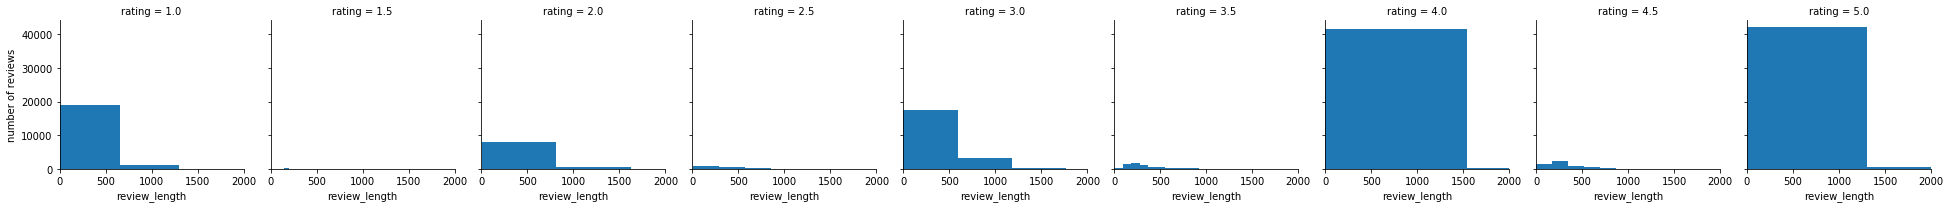

In [6]:
# check how the review lengths are distributed

ax = sns.FacetGrid(data=df, col='rating', xlim=(0, 2000)).map(plt.hist, 'review_length', bins=50)
ax.axes[0][0].set(ylabel='number of reviews');

In [7]:
sns.barplot

<function seaborn.categorical.barplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None, estimator=<function mean at 0x000002379CDF3488>, ci=95, n_boot=1000, units=None, orient=None, color=None, palette=None, saturation=0.75, errcolor='.26', errwidth=None, capsize=None, dodge=True, ax=None, **kwargs)>

In [8]:
df_casual = df[df.restaurant_type=='Casual Dining']

In [9]:
df_casual.to_csv('Review_CD.csv',index = False)

In [24]:
pos_reviews = df_casual.review[df_casual.rating>3].values
neg_reviews = df_casual.review[df_casual.rating<3].values
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  25,553
Negative Reviews:  8,356


In [25]:
# additional stopwords
from sklearn.feature_extraction import text 
extra_words = ['ve', 'like', 'got', 'Cleveland', 'just', 
               'don', 'really', 'said', 'told', 'ok',
               'came', 'went', 'did', 'didn', 'good']
stop_words = text.ENGLISH_STOP_WORDS.union(extra_words)



#### TFIDF

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 20000
random_neg = np.random.choice(neg_reviews, size=num_reviews)
random_pos = np.random.choice(pos_reviews, size=num_reviews)

dicty = {'pizzas':'pizza', 'burgers':'burger', 'ordered':'order',
         'prices':'price', 'topping':'toppings'}
def replace_words(text, dicty):
    '''Returns text with word substitutions made according
       to the passed `dicty` dictionary'''
    for i,j in dicty.items():
        text = text.replace(i,j)
    return text

random_neg = [replace_words(w, dicty) for w in random_neg]
random_pos = [replace_words(w, dicty) for w in random_pos]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(random_neg)
pos_vectors = tfidf_pos.fit_transform(random_pos)

C:\Users\91907\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cleveland'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\91907\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cleveland'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [27]:


# Store TFIDF vectors in a Pandas DataFrame to investigate further
neg_df = pd.DataFrame(neg_vectors.todense(), columns=[tfidf_neg.get_feature_names()])
pos_df = pd.DataFrame(pos_vectors.todense(), columns=[tfidf_pos.get_feature_names()])

# get mean for each column (word): highest means are most important words
col_means_neg = {}
for col in neg_df:
    col_means_neg[col] = neg_df[col].mean()

col_means_pos = {}
for col in pos_df:
    col_means_pos[col] = pos_df[col].mean()



In [31]:


no_top_words = 10

print('Top %d words in POSITIVE reviews:' %no_top_words, end='')
print(sorted(col_means_pos, key=col_means_pos.get, reverse=True)[:no_top_words])

print('Top %d words in NEGATIVE reviews:' %no_top_words, end='')
print(sorted(col_means_neg, key=col_means_neg.get, reverse=True)[:no_top_words])



Top 10 words in POSITIVE reviews:[('chicken',), ('service',), ('nice',), ('taste',), ('ambience',), ('great',), ('biryani',), ('order',), ('try',), ('restaurant',)]
Top 10 words in NEGATIVE reviews:[('order',), ('chicken',), ('bad',), ('place',), ('taste',), ('worst',), ('service',), ('biryani',), ('restaurant',), ('quality',)]


In [32]:
# delete dataframes to save memory
del neg_df
del pos_df

#### LSA

In [33]:
# LSA
from gensim import corpora, models, similarities, matutils

# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants terms by docs instead of docs by terms
tfidf_pos_corpus = matutils.Sparse2Corpus(pos_vectors.transpose())
tfidf_neg_corpus = matutils.Sparse2Corpus(neg_vectors.transpose())

# Row indices
id2word_pos = dict((v,k) for k,v in tfidf_pos.vocabulary_.items())
id2word_neg = dict((v,k) for k,v in tfidf_neg.vocabulary_.items())

# This is a hack for Python 3!
id2word_pos = corpora.Dictionary.from_corpus(tfidf_pos_corpus, id2word=id2word_pos)
id2word_neg = corpora.Dictionary.from_corpus(tfidf_neg_corpus, id2word=id2word_neg)

In [34]:
# create LSA model
num_topics = 20
lsi_pos = models.LsiModel(tfidf_pos_corpus, id2word=id2word_pos, num_topics=num_topics)
lsi_neg = models.LsiModel(tfidf_neg_corpus, id2word=id2word_neg, num_topics=num_topics)

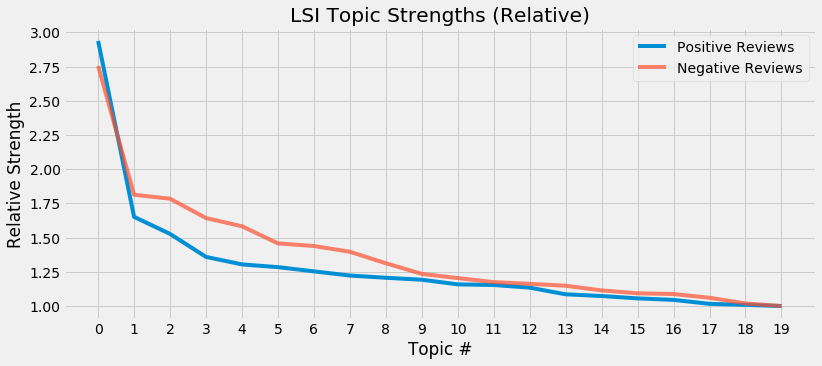

In [35]:
# elbow plot
singular_values_pos = lsi_pos.projection.s.tolist()
singular_values_pos_rel = [sv/singular_values_pos[-1] for sv in singular_values_pos]
singular_values_neg = lsi_neg.projection.s.tolist()
singular_values_neg_rel = [sv/singular_values_neg[-1] for sv in singular_values_neg]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
plt.plot(range(len(singular_values_pos)), singular_values_pos_rel, label='Positive Reviews', alpha=1.0)
plt.plot(range(len(singular_values_neg)), singular_values_neg_rel, label='Negative Reviews', alpha=0.7)
plt.xticks(range(len(singular_values_pos)), range(len(singular_values_pos)))
plt.xlabel('Topic #')
plt.ylabel('Relative Strength')
plt.title('LSI Topic Strengths (Relative)')
plt.legend(loc=0, fontsize='medium');

In [36]:
topics_to_print = 5

In [37]:
# look at top positive topics
print('Top %d topics for POSITIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_pos.show_topics()[0:topics_to_print])

Top 5 topics for POSITIVE reviews
---------------------------------
[(0,
  '0.281*"chicken" + 0.221*"service" + 0.203*"biryani" + 0.180*"nice" + '
  '0.178*"great" + 0.177*"taste" + 0.172*"ambience" + 0.159*"order" + '
  '0.149*"try" + 0.143*"restaurant"'),
 (1,
  '0.586*"biryani" + -0.427*"nice" + 0.409*"chicken" + -0.195*"service" + '
  '-0.142*"ambience" + -0.135*"great" + -0.119*"staff" + 0.116*"mutton" + '
  '-0.114*"pizza" + 0.097*"biriyani"'),
 (2,
  '0.858*"nice" + 0.307*"biryani" + -0.152*"great" + 0.099*"chicken" + '
  '-0.094*"amazing" + -0.085*"pizza" + 0.069*"taste" + -0.063*"service" + '
  '-0.061*"restaurant" + -0.061*"best"'),
 (3,
  '0.431*"biryani" + -0.389*"chicken" + 0.362*"awesome" + 0.284*"taste" + '
  '0.254*"great" + 0.207*"service" + -0.180*"veg" + -0.142*"biriyani" + '
  '0.133*"quality" + -0.111*"nice"'),
 (4,
  '-0.603*"awesome" + 0.438*"biryani" + -0.318*"taste" + -0.291*"biriyani" + '
  '-0.173*"chicken" + -0.153*"delivery" + 0.132*"pizza" + -0.101*"qualit

In [38]:


# look at top negative topics
print('Top %d topics for NEGATIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_neg.show_topics()[0:topics_to_print])



Top 5 topics for NEGATIVE reviews
---------------------------------
[(0,
  '0.300*"order" + 0.294*"chicken" + 0.285*"bad" + 0.260*"worst" + '
  '0.246*"taste" + 0.237*"biryani" + 0.209*"place" + 0.183*"service" + '
  '0.162*"restaurant" + 0.158*"quality"'),
 (1,
  '0.848*"bad" + -0.281*"biryani" + -0.244*"chicken" + 0.160*"taste" + '
  '-0.152*"order" + -0.137*"worst" + 0.136*"quality" + -0.069*"rice" + '
  '0.067*"service" + -0.051*"delivered"'),
 (2,
  '0.900*"worst" + -0.246*"chicken" + -0.194*"biryani" + 0.081*"service" + '
  '-0.081*"quantity" + -0.075*"rice" + -0.062*"pieces" + 0.058*"experience" + '
  '-0.053*"mutton" + -0.052*"order"'),
 (3,
  '0.525*"biryani" + 0.329*"chicken" + -0.250*"place" + 0.230*"bad" + '
  '0.227*"worst" + 0.211*"taste" + -0.209*"service" + -0.183*"order" + '
  '-0.150*"restaurant" + -0.148*"delivery"'),
 (4,
  '0.718*"taste" + 0.391*"quantity" + -0.317*"bad" + -0.237*"order" + '
  '0.194*"quality" + -0.135*"chicken" + -0.124*"biryani" + -0.118*"deliver

#### NMF

In [39]:
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

In [40]:


def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 6

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)



Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   3.366*chicken, 1.093*order, 1.087*biriyani, 0.807*rice, 0.674*tasty, 0.567*spicy
Topic 1:   3.172*biryani, 0.398*taste, 0.368*mutton, 0.289*quantity, 0.281*hyderabadi, 0.248*dum
Topic 2:   3.666*nice, 0.197*taste, 0.144*ambience, 0.140*tasty, 0.119*service, 0.097*family
Topic 3:   1.598*service, 1.370*great, 1.161*ambience, 0.835*staff, 0.813*restaurant, 0.813*visit
Topic 4:   3.076*awesome, 0.723*taste, 0.241*delivery, 0.182*quantity, 0.170*biriyani, 0.161*quality
Topic 5:   2.332*veg, 1.287*non, 0.543*starters, 0.397*buffet, 0.339*main, 0.324*course

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   2.330*place, 1.609*service, 0.821*average, 0.806*restaurant, 0.770*ambience, 0.763*quality
Topic 1:   3.793*bad, 0.411*quality, 0.302*experience, 0.182*service, 0.085*packaging, 0.077*pieces
Topic 2:   3.775*worst, 0.280*experience, 0.243*service, 0.166*resta

##### Review Similarity in NMF space

In [61]:


# look at a random positive review
review_num_p = np.random.randint(0, high=len(random_pos))
print(review_num_p)
print(random_pos[review_num_p])


# look at a random negative review
review_num_n = np.random.randint(0, high=len(random_neg))
print(review_num_n)
print(random_neg[review_num_n])


10357
Loved the place  A casual dining area  Indoor  has an option of seating outdoor as well where it gives a sight of in house swimming pool  Live Bar  didn   x83   x83   x82   x82   x83   x82   x82   x92t tried drinks  looks fascinating  Food we tried was definitely good  All of that staffs here an asset 
10667
Worst food ever  The packing was horrible  Paneer was stale  Naan were made of rubber   it was already cold at the time of delivery  Got curd instead of raita  cucumber instead of salad Horrible Experience  


In [62]:
# compute cosine similarities of this review with all other reviews in the new space
import sklearn.metrics.pairwise as smp

cosines_pos = {}
for ind_p, review_p in enumerate(W_pos):
    similarity_p = smp.cosine_similarity(W_pos[review_num_p].reshape(1,-1), review_p.reshape(1,-1))
    cosines_pos[ind_p] = similarity_p[0][0]

cosines_neg = {}
for ind_n, review_n in enumerate(W_neg):
    similarity_n = smp.cosine_similarity(W_pos[review_num_n].reshape(1,-1), review_n.reshape(1,-1))
    cosines_neg[ind_n] = similarity_n[0][0]

In [63]:
# get top 3 matching reviews
for n in sorted(cosines_pos, key=cosines_pos.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines_pos[n]))
    print(random_pos[n])
print('-'*50)
print('\n')


# get top 3 matching reviews
for n in sorted(cosines_neg, key=cosines_neg.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines_neg[n]))
    print(random_neg[n])
print('-'*50)

--------------------------------------------------
>> Similarity 1.000
Loved the place  A casual dining area  Indoor  has an option of seating outdoor as well where it gives a sight of in house swimming pool  Live Bar  didn   x83   x83   x82   x82   x83   x82   x82   x92t tried drinks  looks fascinating  Food we tried was definitely good  All of that staffs here an asset 
--------------------------------------------------
>> Similarity 1.000
The ambience is the biggest USP of this place  Beautiful rooftop sitting space  well ventilated although not air conditioned and the ambient lighting is beautiful  However  when it comes to table service and the overall service  it does not farw anywhere over the average  Food is good but not the best  Must try is Tandoori Supreme main course platter and the Chocolate Mud Pot dessert  The place does not serve food till 1 although it stays open and the last order we could place was at 11 30 which was a bummer  However  overall it definitely deserve 

#### Count Vectorizer

In [64]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts
cv_pos = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

cv_neg = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 15000
cv_random_neg = np.random.choice(neg_reviews, size=num_reviews)
cv_random_pos = np.random.choice(pos_reviews, size=num_reviews)

# replace words from defined dictionary 'dicty'
cv_random_neg = [replace_words(w, dicty) for w in cv_random_neg]
cv_random_pos = [replace_words(w, dicty) for w in cv_random_pos]

# Get the cv vectors
cv_neg_vectors = cv_neg.fit_transform(cv_random_neg).transpose()
cv_pos_vectors = cv_pos.fit_transform(cv_random_pos).transpose()

C:\Users\91907\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cleveland'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\91907\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cleveland'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [65]:
# Convert sparse matrix of counts to a gensim corpus
corpus_neg = matutils.Sparse2Corpus(cv_neg_vectors)
corpus_pos = matutils.Sparse2Corpus(cv_pos_vectors)

# save a mapping (dict) of row id to word (token) for later use by gensim 
id2word_cv_pos = dict((v, k) for k, v in cv_pos.vocabulary_.items())
id2word_cv_neg = dict((v, k) for k, v in cv_neg.vocabulary_.items())

#### LDA

In [66]:
# create lda multicore model
lda_pos = models.ldamulticore.LdaMulticore(corpus=corpus_pos, num_topics=5, 
                                           id2word=id2word_cv_pos, passes=10, workers=15)
lda_neg = models.ldamulticore.LdaMulticore(corpus=corpus_neg, num_topics=5, 
                                           id2word=id2word_cv_neg, passes=10, workers=15)

In [67]:
print('Top topics + words for POSITIVE reviews')
print('-'*39)
pprint(lda_pos.print_topics(num_words=7))

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
pprint(lda_neg.print_topics(num_words=7))

Top topics + words for POSITIVE reviews
---------------------------------------
[(0,
  '0.021*"chicken" + 0.014*"order" + 0.013*"taste" + 0.012*"ambience" + '
  '0.011*"try" + 0.011*"service" + 0.010*"visit"'),
 (1,
  '0.016*"service" + 0.014*"amazing" + 0.013*"pizza" + 0.013*"try" + '
  '0.011*"best" + 0.010*"great" + 0.010*"ambience"'),
 (2,
  '0.037*"chicken" + 0.024*"biryani" + 0.017*"order" + 0.013*"taste" + '
  '0.012*"try" + 0.009*"biriyani" + 0.009*"mutton"'),
 (3,
  '0.026*"service" + 0.021*"ambience" + 0.019*"nice" + 0.017*"great" + '
  '0.017*"staff" + 0.013*"restaurant" + 0.011*"taste"'),
 (4,
  '0.014*"service" + 0.012*"restaurant" + 0.012*"best" + 0.011*"chicken" + '
  '0.010*"veg" + 0.010*"ambience" + 0.008*"price"')]

Top topics + words for NEGATIVE reviews
---------------------------------------
[(0,
  '0.048*"order" + 0.023*"delivery" + 0.014*"restaurant" + 0.013*"service" + '
  '0.012*"delivered" + 0.011*"time" + 0.008*"quantity"'),
 (1,
  '0.052*"chicken" + 0.040*"o

#### Continuing with NMF

In [68]:
# let's remind ourselves of the POSITIVE topics
print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   3.366*chicken, 1.093*order, 1.087*biriyani, 0.807*rice, 0.674*tasty, 0.567*spicy
Topic 1:   3.172*biryani, 0.398*taste, 0.368*mutton, 0.289*quantity, 0.281*hyderabadi, 0.248*dum
Topic 2:   3.666*nice, 0.197*taste, 0.144*ambience, 0.140*tasty, 0.119*service, 0.097*family
Topic 3:   1.598*service, 1.370*great, 1.161*ambience, 0.835*staff, 0.813*restaurant, 0.813*visit
Topic 4:   3.076*awesome, 0.723*taste, 0.241*delivery, 0.182*quantity, 0.170*biriyani, 0.161*quality
Topic 5:   2.332*veg, 1.287*non, 0.543*starters, 0.397*buffet, 0.339*main, 0.324*course


In [69]:
# we can investigate a random positive review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_pos))
print('Positive Review #%d' %review_num)
print('-'*25)
print(random_pos[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_pos[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Positive Review #8417
-------------------------
The place is a gold find  Dropped in here for an ad hoc brunch  meticulous preparation goes into every single order placed  English breakfast   Ivy League in Kalyan Nagar 
-------------------------
Topic 0: 0.0074
Topic 3: 0.0060
Topic 1: 0.0002
Topic 2: 0.0000
Topic 4: 0.0000
Topic 5: 0.0000


In [70]:


print('Top topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)



Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   2.330*place, 1.609*service, 0.821*average, 0.806*restaurant, 0.770*ambience, 0.763*quality
Topic 1:   3.793*bad, 0.411*quality, 0.302*experience, 0.182*service, 0.085*packaging, 0.077*pieces
Topic 2:   3.775*worst, 0.280*experience, 0.243*service, 0.166*restaurant, 0.150*waste, 0.146*life
Topic 3:   2.520*chicken, 2.478*biryani, 0.814*rice, 0.557*pieces, 0.466*mutton, 0.402*biriyani
Topic 4:   3.357*taste, 1.381*quantity, 0.538*quality, 0.291*poor, 0.134*spicy, 0.120*price
Topic 5:   2.634*order, 1.296*delivered, 1.269*delivery, 0.647*restaurant, 0.610*late, 0.549*time


In [71]:
# now investigate a random negative review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_neg))
print('Negative Review #%d' %review_num)
print('-'*25)
print(random_neg[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_neg[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Negative Review #2857
-------------------------
Ordered in from this place coz we thought we'll try a new place for a change  We order a Khymanu unddo and chicken kolhapuri gravy  We found the quantity and quality less for the price  The only reason I'm giving the rating of 2 5 is for the Khymanu unddho which was quite tasty in comparison to the gravy dish  The gravy was only spice and no other taste and had hardly any pieces of chicken  Will not try this place again   
-------------------------
Topic 3: 0.0418
Topic 0: 0.0375
Topic 4: 0.0373
Topic 5: 0.0061
Topic 1: 0.0000
Topic 2: 0.0000


#### Topic From all the reviews

In [76]:
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  25,553
Negative Reviews:  8,356


In [77]:

# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# replace words with defined dictionary 'dicty'
pos_reviews = [replace_words(w, dicty) for w in pos_reviews]
neg_reviews = [replace_words(w, dicty) for w in neg_reviews]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(neg_reviews)
pos_vectors = tfidf_pos.fit_transform(pos_reviews)

C:\Users\91907\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cleveland'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\91907\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cleveland'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [159]:
H_pos

array([[2.21188584e-03, 4.31839415e-03, 3.90455847e-03, ...,
        1.46066126e-01, 8.76253642e-03, 2.34287733e-03],
       [1.54384257e-05, 5.17344919e-03, 0.00000000e+00, ...,
        7.10434776e-03, 1.45635968e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.54477227e-03, 2.28824551e-03, 1.71632424e-03, ...,
        1.44645433e-01, 1.14446589e-02, 5.42396947e-03],
       [0.00000000e+00, 2.32146088e-03, 2.27005287e-03, ...,
        2.95226983e-02, 0.00000000e+00, 0.00000000e+00],
       [1.60132496e-04, 8.36286854e-04, 1.21850527e-04, ...,
        5.52685596e-04, 0.00000000e+00, 0.00000000e+00]])

In [78]:
# NMF for all reviews
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

In [81]:


no_topics = num_topics
no_top_words = 5

print('Topics for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTopics for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)



Topics for POSITIVE reviews
---------------------------------------
Topic 0:   3.467*chicken, 1.218*biriyani, 1.136*order, 0.871*rice, 0.720*tasty
Topic 1:   3.364*biryani, 0.393*mutton, 0.317*chicken, 0.275*best, 0.264*dum
Topic 2:   3.883*nice, 0.155*ambience, 0.143*tasty, 0.114*friends, 0.107*staff
Topic 3:   1.842*service, 1.540*great, 1.281*ambience, 0.932*staff, 0.884*visit
Topic 4:   2.723*taste, 1.912*awesome, 0.737*quality, 0.668*quantity, 0.521*delivery
Topic 5:   2.275*veg, 1.258*non, 0.534*starters, 0.365*buffet, 0.324*main

Topics for NEGATIVE reviews
---------------------------------------
Topic 0:   1.970*place, 1.401*service, 0.696*average, 0.680*ambience, 0.631*restaurant
Topic 1:   3.049*bad, 0.332*quality, 0.259*experience, 0.140*service, 0.051*cold
Topic 2:   3.093*worst, 0.254*experience, 0.175*service, 0.132*restaurant, 0.131*waste
Topic 3:   2.313*chicken, 2.112*biryani, 0.770*rice, 0.518*pieces, 0.437*mutton
Topic 4:   2.759*taste, 0.970*quantity, 0.667*quality,

In [82]:
# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'biryani/order', 1:'Mutton_Biryani', 2:'Ambience', 
              3:'Service/Staff', 4:'Quality/Quantity', 5:'Buffet'}

neg_topics = {0:'Ambience/Service', 1:'Quality/service', 2:'Experience', 
              3:'BIryani', 4:'Quality/Quantity', 5:'Delivery/Order'}

In [83]:


# we create dataframes for positive & negative reviews that we can
# later add topic information to
df_pos = df_casual[['restaurant', 'rating', 'review', 'review_length']][df_casual.rating>3].reset_index()
df_neg = df_casual[['restaurant', 'rating', 'review', 'review_length']][df_casual.rating<3].reset_index()
df_pos.drop(labels='index', axis=1, inplace=True)
df_neg.drop(labels='index', axis=1, inplace=True)



In [85]:
print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [0.         0.         0.         0.01786169 0.02201093 0.00449164]
Sum of weights:  0.0443642610604596


##### Normalizing the Topic Scores

In [87]:
# add normalized topic weights to each review
from sklearn.preprocessing import normalize
df_pos = pd.concat([df_pos, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
df_neg = pd.concat([df_neg, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)

In [88]:
df_neg.head()

,restaurant,rating,review,review_length,0,1,2,3,4,5
0,Jalsa,2.0,Its a restaurant near to Banashankari BDA Me ...,329,0.696424,0.000000,0.000000,0.000000,0.000000,0.303576
1,Spice Elephant,2.0,I had a very bad experience here I don't know...,739,0.325538,0.392497,0.205325,0.076639,0.000000,0.000000
2,Spice Elephant,2.0,Spice elephant soup SPL almost manchow flavou...,424,0.196259,0.325238,0.000000,0.143885,0.297119,0.037499
3,Szechuan Dragon,1.0,One more place with wrong over rating stars ...,284,0.386925,0.499827,0.000000,0.028491,0.000000,0.084756
4,Empire Restaurant,2.0,It is one of the big outlets of Empire Having...,728,0.543237,0.000000,0.000000,0.191413,0.103019,0.162331


In [89]:
# group by business_id and apply mean/count functions to columns
df_pos_bsns = df_pos.groupby('restaurant').agg({'rating':'mean', 'review':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()
df_neg_bsns = df_neg.groupby('restaurant').agg({'rating':'mean', 'review':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()

In [ ]:
df_pos_bsns.head()

In [141]:
# scores = df_pos_bsns[df_pos_bsns.restaurant == '100 C'].iloc[:,-6:].values
# print(df_casual[df_casual.restaurant == '100 C']['restaurant'].values[0] + ' - Positive Reviews')
# print('-'*36)
# for n in pos_topics:
#     print('Topic {}: {:18} > {:.4f}'.format(n, pos_topics[n], scores[0][n]))
    


In [ ]:
df_pos.to_csv('pos_reviews.csv')
df_neg.to_csv('neg_reviews.csv')
df_pos_bsns.to_csv('pos_reviews_combined.csv')
df_neg_bsns.to_csv('neg_reviews_combined.csv')

#### KMeans Clustering

In [137]:
df11 = pd.read_csv('pos_reviews_combined.csv')


In [200]:
df11.restaurant.replace("  ","",regex = True,inplace = True)

In [153]:
df12 = pd.read_csv('neg_reviews_combined.csv')

In [201]:
df12.restaurant.replace("  ","",regex = True,inplace = True)

In [139]:
df11.drop('Unnamed: 0',axis = 1,inplace = True)

In [154]:
df12.drop('Unnamed: 0',axis = 1,inplace = True)

In [163]:
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [145]:
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
# tsne_results = tsne.fit_transform(df11.iloc[:,4:10])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1482 samples in 0.002s...
[t-SNE] Computed neighbors for 1482 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1482
[t-SNE] Computed conditional probabilities for sample 1482 / 1482
[t-SNE] Mean sigma: 0.074048
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.991325
[t-SNE] KL divergence after 1000 iterations: 0.979768


In [155]:
# tsne1 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
# tsne_results1 = tsne1.fit_transform(df12.iloc[:,4:10])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 962 samples in 0.010s...
[t-SNE] Computed neighbors for 962 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 962 / 962
[t-SNE] Mean sigma: 0.098023
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.331142
[t-SNE] KL divergence after 1000 iterations: 0.860360


In [146]:
#     df11['tsne1'] = tsne_results[:,0]
#     df11['tsne2'] = tsne_results[:,1]

In [156]:
# df12['tsne1'] = tsne_results1[:,0]
# df12['tsne2'] = tsne_results1[:,1]

In [150]:
df11.columns = ['restaurant', 'rating', 'review', 'review_length','biryani_order','Mutton_Biryani','Ambience','Service_Staff', 'Quality_Quantity', 'Buffet','tsne1', 'tsne2']

In [158]:
df12.columns = ['restaurant', 'rating', 'review', 'review_length','Ambience_Service', 'Quality_service', 'Experience','BIryani','Quality_Quantity', 'Delivery_Order','tsne1', 'tsne2']

In [151]:
df11.head()

,restaurant,rating,review,review_length,biryani_order,Mutton_Biryani,Ambience,Service_Staff,Quality_Quantity,Buffet,tsne1,tsne2
0,Biryani Central,4.000,2,214.500,0.179443,0.547793,0.163630,0.009177,0.099957,0.000000,46.860527,1.057189
1,The Bbq,4.000,2,565.000,0.182969,0.128991,0.000000,0.138047,0.107126,0.442866,-26.102589,-31.013386
2,Italy,4.500,2,243.000,0.152837,0.013811,0.026576,0.789254,0.017522,0.000000,-43.054707,9.310807
3,Vibes Restro,5.000,1,150.000,0.024352,0.032702,0.000000,0.554878,0.341050,0.047018,-2.130068,-22.597075
4,100 C,4.625,16,282.125,0.295273,0.233111,0.058193,0.114440,0.273331,0.025652,34.604137,5.148355


In [159]:
df12.head()

,restaurant,rating,review,review_length,Ambience_Service,Quality_service,Experience,BIryani,Quality_Quantity,Delivery_Order,tsne1,tsne2
0,100 C,1.285714,7,195.000000,0.245130,0.001881,0.076022,0.405248,0.062449,0.209268,5.396239,17.156336
1,1441 Pizzeria,2.000000,1,618.000000,0.591834,0.089434,0.030491,0.000000,0.266979,0.021262,12.526060,-10.657610
2,1722 Urban Bistro,1.750000,4,231.750000,0.414430,0.161074,0.000000,0.110921,0.080509,0.233066,-9.851998,-8.069964
3,1947,1.000000,3,655.333333,0.400095,0.010692,0.081753,0.093934,0.031450,0.382076,-22.236788,3.180169
4,2 Statez,1.000000,1,399.000000,0.232571,0.020517,0.039196,0.233359,0.000000,0.474357,-23.122963,10.237085


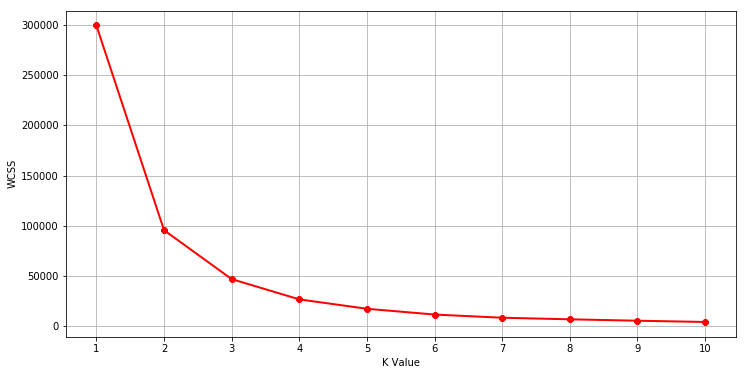

In [160]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(df11.iloc[:,4:10])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()



In [191]:
km_p = KMeans(n_clusters=4,init="k-means++")
clusters = km_p.fit_predict(df11.iloc[:,4:10])
df11["label"] = clusters

In [192]:
silhouette_score(df11.iloc[:,4:10],labels = km_p.labels_)

0.5454304391689138

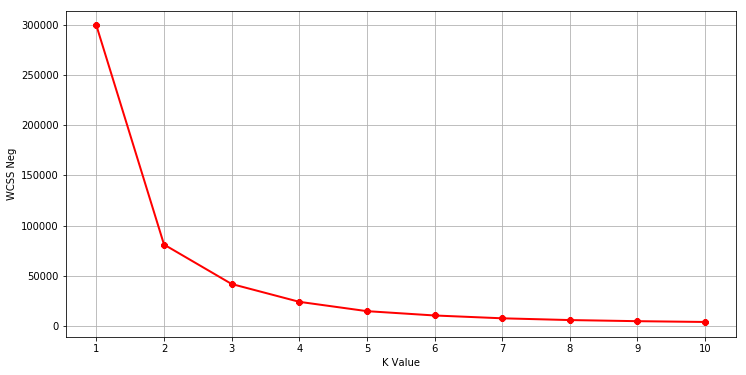

In [165]:

wcss_n = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(df12.iloc[:,4:10])
    wcss_n.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss_n, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS Neg")
plt.show()





In [193]:
km_n = KMeans(n_clusters=4,init="k-means++")
clusters = km_n.fit_predict(df12.iloc[:,4:10])
df12["label"] = clusters

In [194]:
silhouette_score(df12.iloc[:,4:10],labels = km_n.labels_)

0.5603292052650382

In [197]:
df11[(df11.review >=10) & (df11.label == 0)]

,restaurant,rating,review,review_length,biryani_order,Mutton_Biryani,Ambience,Service_Staff,Quality_Quantity,Buffet,tsne1,tsne2,label
7,1947,4.166667,48,388.958333,0.057836,0.030320,0.097409,0.382053,0.099142,0.333241,-25.234114,-22.952934,0
11,24th Main,4.300000,10,409.300000,0.028908,0.003965,0.081378,0.289039,0.104700,0.492010,-28.374153,-28.099382,0
14,36th Cross Coffee Mane,4.500000,13,392.846154,0.114733,0.098014,0.102865,0.273721,0.222960,0.187707,22.362080,-15.961496,0
31,Aagaman Veg,4.272727,11,535.727273,0.083744,0.005659,0.139394,0.301278,0.154084,0.315841,-22.069731,-25.535416,0
75,Ambika Vegetarian Hotel,4.100000,10,230.500000,0.113184,0.133791,0.092414,0.369068,0.092991,0.198551,-17.118750,-14.459650,0
94,Annalakshmi,4.411765,17,429.941176,0.161815,0.053325,0.030559,0.364184,0.226964,0.163153,-6.245864,-14.408498,0
102,Apna Veg Dhaba,4.785714,14,182.785714,0.077064,0.013869,0.018197,0.209025,0.370719,0.168270,9.365179,-20.691158,0
115,Atithi,4.161905,105,351.323810,0.065159,0.024607,0.063461,0.359609,0.133011,0.316058,-24.297810,-22.682806,0
120,Axomi Taste of Assam,4.187500,16,557.875000,0.185544,0.030528,0.007977,0.362800,0.320139,0.093012,6.434314,-14.333488,0
143,Banjara Melting Pot,4.333333,12,307.083333,0.045144,0.108513,0.125641,0.315274,0.130752,0.274676,-22.793720,-24.444019,0


In [206]:
df11 = df11[df11.review>=10]

In [207]:
df11.reset_index(inplace = True,drop = 'index')

In [209]:
df11.columns = ['restaurant', 'rating', 'review', 'review_length', 'biryani_order',
       'Biryani', 'Ambience', 'Service', 'Quality',
       'Buffet', 'tsne1', 'tsne2', 'label']

In [210]:
df11.to_csv('Pos_review_summary.csv',index=False)

In [203]:
df12.to_csv('Neg_review_summary.csv',index=False)